In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
energy = pd.read_csv('/content/drive/MyDrive/빅데이터 분석 실습/[실전과제] 에너지 사용량 예측/에너지 사용량 예측.csv')
energy

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
0,ABC,2016-01-01 0:15,5,3,1,-2.5,99.0,229
1,ABC,2016-01-01 0:30,5,3,1,-2.5,99.0,231
2,ABC,2016-01-01 0:45,5,3,1,-2.5,99.0,231
3,ABC,2016-01-01 1:00,5,3,1,-3.1,100.0,226
4,ABC,2016-01-01 1:15,5,3,2,-3.1,100.0,229
...,...,...,...,...,...,...,...,...
70171,ABC,2017-12-31 23:00,7,3,23,-1.6,42.0,278
70172,ABC,2017-12-31 23:15,7,3,24,-1.6,42.0,281
70173,ABC,2017-12-31 23:30,7,3,24,-1.6,42.0,292
70174,ABC,2017-12-31 23:45,7,3,24,-1.6,42.0,293


In [ ]:
energy = energy.drop(['b_name'],axis = 1)

In [ ]:
energy

,daq_time,wday,day_type,hour,temp,rh,p_usage
0,2016-01-01 0:15,5,3,1,-2.5,99.0,229
1,2016-01-01 0:30,5,3,1,-2.5,99.0,231
2,2016-01-01 0:45,5,3,1,-2.5,99.0,231
3,2016-01-01 1:00,5,3,1,-3.1,100.0,226
4,2016-01-01 1:15,5,3,2,-3.1,100.0,229
...,...,...,...,...,...,...,...
70171,2017-12-31 23:00,7,3,23,-1.6,42.0,278
70172,2017-12-31 23:15,7,3,24,-1.6,42.0,281
70173,2017-12-31 23:30,7,3,24,-1.6,42.0,292
70174,2017-12-31 23:45,7,3,24,-1.6,42.0,293


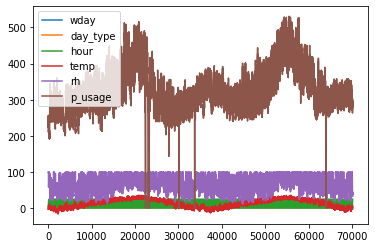

In [ ]:
energy.plot()

In [ ]:
zero_index = list(energy[energy['p_usage'] == 0].index)
for i in zero_index:
    energy.loc[i,'p_usage'] = energy.loc[i-1,'p_usage']

In [ ]:
energy[energy['p_usage'] == 0].value_counts().sum()

0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

energy.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['wday', 'day_type', 'hour', 'temp','rh']
energy_scaled = scaler.fit_transform(energy[scale_cols])
energy_scaled = pd.DataFrame(energy_scaled)
energy_scaled.columns = scale_cols

energy_scaled

,wday,day_type,hour,temp,rh
0,0.666667,1.0,0.000000,0.262452,0.988764
1,0.666667,1.0,0.000000,0.262452,0.988764
2,0.666667,1.0,0.000000,0.262452,0.988764
3,0.666667,1.0,0.000000,0.250958,1.000000
4,0.666667,1.0,0.043478,0.250958,1.000000
...,...,...,...,...,...
70171,1.000000,1.0,0.956522,0.279693,0.348315
70172,1.000000,1.0,1.000000,0.279693,0.348315
70173,1.000000,1.0,1.000000,0.279693,0.348315
70174,1.000000,1.0,1.000000,0.279693,0.348315


In [ ]:
energy = pd.concat([energy[['p_usage','daq_time']], energy_scaled], axis = 1)
energy

,p_usage,daq_time,wday,day_type,hour,temp,rh
0,229,2016-01-01 0:15,0.666667,1.0,0.000000,0.262452,0.988764
1,231,2016-01-01 0:30,0.666667,1.0,0.000000,0.262452,0.988764
2,231,2016-01-01 0:45,0.666667,1.0,0.000000,0.262452,0.988764
3,226,2016-01-01 1:00,0.666667,1.0,0.000000,0.250958,1.000000
4,229,2016-01-01 1:15,0.666667,1.0,0.043478,0.250958,1.000000
...,...,...,...,...,...,...,...
70171,278,2017-12-31 23:00,1.000000,1.0,0.956522,0.279693,0.348315
70172,281,2017-12-31 23:15,1.000000,1.0,1.000000,0.279693,0.348315
70173,292,2017-12-31 23:30,1.000000,1.0,1.000000,0.279693,0.348315
70174,293,2017-12-31 23:45,1.000000,1.0,1.000000,0.279693,0.348315


In [ ]:
TEST_SIZE = 7000
WINDOW_SIZE = 10

train = energy[:-TEST_SIZE]
test = energy[-TEST_SIZE:]

In [ ]:
def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['wday', 'day_type', 'hour', 'temp','rh']
label_cols = ['p_usage']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 10)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((50532, 10, 5), (12634, 10, 5))

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((7000, 5), (7000, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.layers import *

model = Sequential()
model.add(LSTM(64, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=True)
          )
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(32, 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [ ]:
import os

adam = keras.optimizers.Adam(lr = 0.0005)
model.compile(loss='mean_squared_error', optimizer= adam)
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model_path = '/content/drive/MyDrive/빅데이터 분석 실습/[실전과제] 에너지 사용량 예측/model'
filename = os.path.join(model_path, 'tmp_checkpoint_dropout.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=3, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=32,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
1580/1580 [==============================] - 25s 14ms/step - loss: 6500.4644 - val_loss: 1836.4681

Epoch 00001: val_loss improved from inf to 1836.46814, saving model to /content/drive/MyDrive/빅데이터 분석 실습/[실전과제] 에너지 사용량 예측/model/tmp_checkpoint_dropout.h5
Epoch 2/200
1580/1580 [==============================] - 21s 13ms/step - loss: 1264.5568 - val_loss: 1128.1086

Epoch 00002: val_loss improved from 1836.46814 to 1128.10864, saving model to /content/drive/MyDrive/빅데이터 분석 실습/[실전과제] 에너지 사용량 예측/model/tmp_checkpoint_dropout.h5
Epoch 3/200
1580/1580 [==============================] - 21s 13ms/step - loss: 1121.7700 - val_loss: 913.9153

Epoch 00003: val_loss improved from 1128.10864 to 913.91528, saving model to /content/drive/MyDrive/빅데이터 분석 실습/[실전과제] 에너지 사용량 예측/model/tmp_checkpoint_dropout.h5
Epoch 4/200
1580/1580 [==============================] - 21s 13ms/step - loss: 1051.1771 - val_loss: 901.4061

Epoch 00004: val_loss improved from 913.91528 to 901.40613, saving model to 

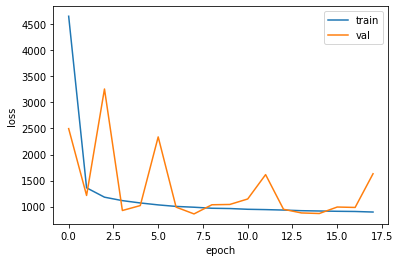

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((6990, 10, 5), (6990, 1))

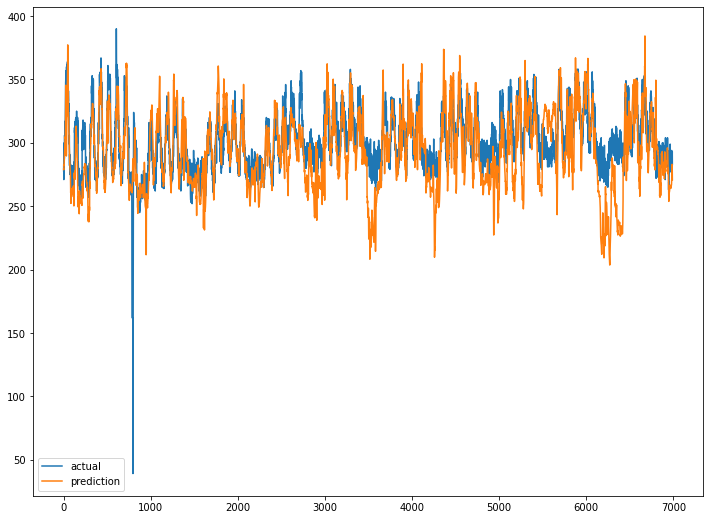

In [ ]:
model.load_weights('/content/drive/MyDrive/빅데이터 분석 실습/[실전과제] 에너지 사용량 예측/model/tmp_checkpoint.h5')

pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()